# Coursework 2 - Methods of Data Science
#### CID: 01501230 - hj2018@ic.ac.uk

## Task 1: Neural Networks

In [105]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import scipy as sc
from scipy.sparse import linalg

We can load our data using tensorflow, retrieving the CIFAR-10 dataset of images from an external website, containing 50000 training and 10000 validation images belonging to 10 classes.

In [106]:
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    return ((x_train, y_train), (x_val, y_val))

(x_train, y_train), (x_val, y_val) = load_data()

Now we reshape the images by flattening the data. Each images is 32x32 in size, with 3 colour channels, hence we can flatten our data for each image to have 3072 columns. We flatten the training and validation x data, and shuffle the training data. Next I remove the final 80 images of the training data, and the final 16 of the validation data, in order to gain equal sized batches. Next I create batches for my training and validation data of size 128 each, to use in my SGD algorithm.

In [107]:
# Flatten data
x_train_flat = x_train.reshape(50000, 3072)
# Construct training data array
train_data = np.hstack((x_train_flat, y_train))
# Shuffle data
np.random.shuffle(train_data)
# Remove final 80 images
train_data = train_data[:49920,:]
# Create batches of training data
train_data_batches = np.split(train_data, 390)

# Flatten data
x_val_flat = x_val.reshape(10000, 3072)
# Construct validation data array
val_data = np.hstack((x_val_flat, y_val))
# Remove final 16 images
val_data = val_data[:9984,:]
# Create batches of validation data
val_data_batches = np.split(val_data, 78)

We can implement a multi-layer Perceptron (MLP) with 5 hidden layers, each with 400 neurons and an output later with 10 neurons, in order to perform a classification task on this dataset of images.

We first define our input layer denoted by $h^{(0)}$ containing our input data $\boldsymbol x \in \mathbb{R}^D$. We also choose the number of hidden layers $L = 5$ in the model, and we define the weights $\boldsymbol W^{(k)} \in \mathbb{R}^{n_k\times n_{k+1}}$for the $k$th layer, with $n_k$ being the number of neurons in the $k$th layer. We have our bias terms $\boldsymbol b^{(k)} \in \mathbb{R}^{n_{k+1}}$ for each layer. We also have $\sigma$ and $\sigma_{out}$ as our activation functions between layers and for the output layer.

$$
\begin{align}
\boldsymbol{h}^{(0)} &:= \boldsymbol{x},\\
\boldsymbol{h}^{(k)} &= \sigma\left((\boldsymbol{h}^{(k-1)})^T \boldsymbol{W}^{(k-1)} + \boldsymbol{b}^{(k-1)} \right),\qquad k=1,\ldots, L,\\
\hat{\boldsymbol{y}} &= \sigma_{out}\left((\boldsymbol{h}^{(L)})^T \boldsymbol{W}^{(L)} + \boldsymbol{b}^{(L)} \right),
\end{align}
$$

We first define a function to sum the product of the inputs $\boldsymbol x$ and weights $\boldsymbol W$ for each layer, before adding the bias term $\boldsymbol b$ to create the dense layer, returning the layer pre-activations.

In [108]:
def dense(x, W, b):
    h = b + x @ W
    return h

Next we can define our activation function between hidden layers $\sigma: \mathbb{R}\mapsto\mathbb{R}$. Here we choose to use $tanh(\cdot)$ as our activation function. We also define the activation function on the output layer, for which we use the softmax function.

In [109]:
def activ(h):
    h = np.tanh(h)
    return h

In [110]:
def softmax(x):
    x_t=x.T
    e_x = np.exp(x_t - np.max(x_t))
    return (e_x / e_x.sum(axis=0)).T

Then we can define our loss function as cross entropy, as follows:

In [111]:
def cross_entropy(predictions, targets):
    N = predictions.shape[0]
    loss = -np.sum(targets*np.log(predictions+1e-10))/N
    return loss

We also need a function which calculates the accuracy between our predictions and the real values of our samples. This can be done by calculating the index of the largest probability of our prediction samples, and checking if this matches the index of the correct class from the targets. 

In [112]:
def get_accuracy(prediction, targets):
    # Find index of largest row value per prediction
    pred_arg = np.argmax(prediction, axis=1)
    # Find index of largest row value per target
    targ_arg = np.argmax(targets, axis = 1)
    N = prediction.shape[0]
    # Initialise accuracy
    accuracy = 0
    # Loop over each row
    for i in range(N):
        # Check if max indexes match
        if pred_arg[i] == targ_arg[i]:
            accuracy += 1/N
    return accuracy

We create a gradient function which takes in our delta errors from each layer and post activations to calculate the gradients of our parameters.

In [113]:
def grads(delta1, delta2, delta3, delta4, delta5, delta6, h0, h1, h2, h3, h4, h5):
     
    grad_W0 = delta1.T @ h0
    grad_b0 = delta1
    grad_W1 = delta2.T @ h1
    grad_b1 = delta2
    grad_W2 = delta3.T @ h2
    grad_b2 = delta3
    grad_W3 = delta4.T @ h3
    grad_b3 = delta4
    grad_W4 = delta5.T @ h4
    grad_b4 = delta5
    grad_W5 = delta6.T @ h5
    grad_b5 = delta6
    
    grad_b0 = np.mean(grad_b0, axis=0)
    grad_b1 = np.mean(grad_b1, axis=0)
    grad_b2 = np.mean(grad_b2, axis=0)
    grad_b3 = np.mean(grad_b3, axis=0)
    grad_b4 = np.mean(grad_b4, axis=0)
    grad_b5 = np.mean(grad_b5, axis=0)
    
    
    return grad_W0.T, grad_b0, grad_W1.T, grad_b1, grad_W2.T, grad_b2, grad_W3.T, grad_b3, grad_W4.T, grad_b4, grad_W5.T, grad_b5

We can now create a function to calculate the output error from the output layer, to calculate the final error for the output neurons. This is also the derivative of our cross entropy loss function with respect to our output activation softmax function.

In [114]:
def output_error(y_batch, a2):
    return (a2 - y_batch) / y_batch.shape[0]

We also require the derivative of our activation function which is $tanh(.)$, to use in our backpropagation algorithm.

In [115]:
def activation_derivative(a1):
    return 1 - np.square(np.tanh(a1))

Now we implement this in our backpropagate function, which backpropagates the errors of the next layer to calculate the error of each previous hidden layer.

In [116]:
def backpropagate(delta6, W5, a5):
    w5delta6 = W5 @ delta6.T
    delta5 = activation_derivative(a5) * w5delta6.T
    return delta5

We are now ready to create our entire SGD function. This takes in the number of epochs desired with a specific learning rate. We initialise our training and validation losses and accuracies, alongside our Glorot initialisation of our kernels and biases. We run the algorithm for each of the 390 training batches and then the 78 validation batches for each epoch, storing our losses and accuracies for each epoch in order to plot later.

In [117]:
def SGD(epochs, learning_rate):
    
    # Pre-allocation of losses and accuracies
    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []
    
    # Initialisation for number of iterations for training and validation data
    train_iterations = 390
    val_iterations = 78
    
    # Glorot initialisation of kernels (and biases)
    var0 = 2. / (400 + 3072)
    W0 = np.random.randn(3072, 400) * np.sqrt(var0)
    b0 = np.zeros(400)

    var1 = 2. / (400 + 400)
    W1 = np.random.randn(400, 400) * np.sqrt(var1)
    b1 = np.zeros(400)

    var2 = 2. / (400 + 400)
    W2 = np.random.randn(400, 400) * np.sqrt(var2)
    b2 = np.zeros(400)

    var3 = 2. / (400 + 400)
    W3 = np.random.randn(400, 400) * np.sqrt(var3)
    b3 = np.zeros(400)

    var4 = 2. / (400 + 400)
    W4 = np.random.randn(400, 400) * np.sqrt(var4)
    b4 = np.zeros(400)

    var5 = 2. / (10 + 400)
    W5 = np.random.randn(400, 10) * np.sqrt(var5)
    b5 = np.zeros(10)
    
    # Loop over each epoch
    for epoch in range(epochs):
        print('Epoch', epoch+1)
        
        # Pre-allocation of losses and accuracy per epoch
        train_losses_per_epoch = []
        train_accuracy_per_epoch = []
        
        # Loop over each batch
        for i in range(train_iterations):
            
            # Split training data into x and y data
            x_train_batch = train_data_batches[i][:,:3072]
            y_train_batch = train_data_batches[i][:,3072:]
            
            # MLP algorithm - forwards propagation
            h0 = x_train_batch
            a1 = dense(h0, W0, b0)
            h1 = activ(a1)
            a2 = dense(h1, W1, b1)
            h2 = activ(a2)
            a3 = dense(h2, W2, b2)
            h3 = activ(a3)
            a4 = dense(h3, W3, b3)
            h4 = activ(a4)
            a5 = dense(h4, W4, b4)
            h5 = activ(a5)
            y = dense(h5, W5, b5)
            y_hat = softmax(y)
            
            # Calculation of cross entropy loss and accuracy, alongside output error delta6
            loss_batch = cross_entropy(y_hat, y_train_batch)
            delta6 = output_error(y_train_batch, y_hat)
            train_losses_per_epoch.append(loss_batch)
            accuracy_batch = get_accuracy(y_hat, y_train_batch)
            train_accuracy_per_epoch.append(accuracy_batch)
            
            # Backpropagation of errors for each hidden layer from delta6
            delta5 = backpropagate(delta6, W5, a5)
            delta4 = backpropagate(delta5, W4, a4)
            delta3 = backpropagate(delta4, W3, a3)
            delta2 = backpropagate(delta3, W2, a2)
            delta1 = backpropagate(delta2, W1, a1)
            
            # Calculation of gradients of all parameters
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3, grad_W4, grad_b4, grad_W5, grad_b5 = grads(delta1, delta2, delta3, delta4, delta5, delta6, h0, h1, h2, h3, h4, h5)
            
            # Update parameters through learning rate and gradients
            W0 -= learning_rate * grad_W0
            b0 -= learning_rate * grad_b0
            W1 -= learning_rate * grad_W1
            b1 -= learning_rate * grad_b1
            W2 -= learning_rate * grad_W2
            b2 -= learning_rate * grad_b2
            W3 -= learning_rate * grad_W3
            b3 -= learning_rate * grad_b3
            W4 -= learning_rate * grad_W4
            b4 -= learning_rate * grad_b4
            W5 -= learning_rate * grad_W5
            b5 -= learning_rate * grad_b5
        
        # Add mean of losses and accuracies across epoch to pre allocated vectors
        train_losses.append(np.mean(train_losses_per_epoch))
        print('Training Loss', np.mean(train_losses_per_epoch))
        train_accuracy.append(np.mean(train_accuracy_per_epoch))    
        print('Training Accuracy', np.mean(train_accuracy_per_epoch))
        
        # Validation loop
        val_losses_per_epoch = []
        val_accuracy_per_epoch = []
        for j in range(val_iterations):
            # Split validation data into x and y datasets
            x_val_batch = val_data_batches[j][:,:3072]
            y_val_batch = val_data_batches[j][:,3072:]

            # MLP algorithm - forwards propagation
            h0 = x_val_batch
            a1 = dense(h0, W0, b0)
            h1 = activ(a1)
            a2 = dense(h1, W1, b1)
            h2 = activ(a2)
            a3 = dense(h2, W2, b2)
            h3 = activ(a3)
            a4 = dense(h3, W3, b3)
            h4 = activ(a4)
            a5 = dense(h4, W4, b4)
            h5 = activ(a5)
            y = dense(h5, W5, b5)
            y_hat = softmax(y)

            # Calculation of cross entropy loss and accuracy of validation data
            loss_batch = cross_entropy(y_hat, y_val_batch)
            val_losses_per_epoch.append(loss_batch)
            accuracy_batch = get_accuracy(y_hat, y_val_batch)
            val_accuracy_per_epoch.append(accuracy_batch)

        # Add mean of losses and accuracies across epoch to pre allocated vectors
        val_losses.append(np.mean(val_losses_per_epoch))
        print('Validation Loss', np.mean(val_losses_per_epoch))
        val_accuracy.append(np.mean(val_accuracy_per_epoch))
        print('Validation Accuracy', np.mean(val_accuracy_per_epoch))

    return (train_losses, train_accuracy, val_losses, val_accuracy)

In [45]:
SGD_model_1 = SGD(40, 0.01)

Epoch 1
Training Loss 1.9443338668385421
Training Accuracy 0.30496794871794874
Validation Loss 1.8339396934491619
Validation Accuracy 0.35336538461538464
Epoch 2
Training Loss 1.7936391285746884
Training Accuracy 0.3664463141025641
Validation Loss 1.7746162993265362
Validation Accuracy 0.3684895833333333
Epoch 3
Training Loss 1.7393161176741236
Training Accuracy 0.38611778846153844
Validation Loss 1.7338733765372853
Validation Accuracy 0.3799078525641026
Epoch 4
Training Loss 1.6959727964555984
Training Accuracy 0.4010416666666667
Validation Loss 1.69898330724956
Validation Accuracy 0.39232772435897434
Epoch 5
Training Loss 1.658581092798448
Training Accuracy 0.4134014423076923
Validation Loss 1.6683941362164607
Validation Accuracy 0.40344551282051283
Epoch 6
Training Loss 1.626548972316612
Training Accuracy 0.42590144230769234
Validation Loss 1.6423151907777287
Validation Accuracy 0.4117588141025641
Epoch 7
Training Loss 1.5991871218917493
Training Accuracy 0.43455528846153846
Validat

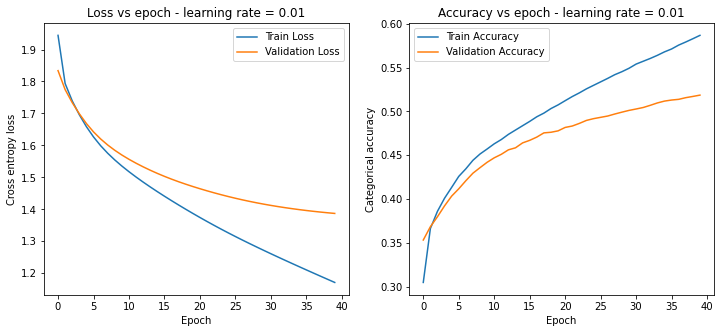

In [118]:
# Plot graphs of epoch vs loss and accuracy for training and validation dataset
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(SGD_model_1[0], label='Train Loss')
plt.plot(SGD_model_1[2], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch - learning rate = 0.01")
plt.legend()

fig.add_subplot(122)
plt.plot(SGD_model_1[1], label='Train Accuracy')
plt.plot(SGD_model_1[3], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch - learning rate = 0.01")
plt.legend()

plt.show()

#### Analysis

Here we observe the training and validation losses and accuracies for the SGD algorithm over 40 epochs and learning rate equal to 0.01. After 40 epochs the training loss has decreased to 1.17 as a rather slow rate, however is not appearing to converge, but rather it has been decreasing linearly since roughly the 15th or 20th epoch. The validation loss however has appeared to display overfitting since the validation loss is converging far above the training loss, reaching just below 1.4 after 40 epochs.

Similarly, the training accuracy appears to be increasing at a slow rate, and past epoch 15-20 has been increasing linearly without a sign to stop even by epoch 40 where it reaches almost 60% accuracy. The validation accuracy has tailed off from the training accuracy, similarly to the losses, and has risen past 50% accuracy.

#### 1.1.2

Now we aim to train the model as we did in 1.1.1 but change the learning rate from 0.01 to 0.0001 and also 0.1. We can plot the losses and accuracies for the training and validation data once again, and compare it to the graphs from 1.1.1.

Epoch 1
Training Loss 2.3305372747846347
Training Accuracy 0.10022035256410257
Validation Loss 2.300706389623642
Validation Accuracy 0.12029246794871795
Epoch 2
Training Loss 2.286988651696748
Training Accuracy 0.14316907051282052
Validation Loss 2.275894370987738
Validation Accuracy 0.16145833333333334
Epoch 3
Training Loss 2.264302610110262
Training Accuracy 0.17349759615384616
Validation Loss 2.2546874610065446
Validation Accuracy 0.18259214743589744
Epoch 4
Training Loss 2.243662954651792
Training Accuracy 0.19503205128205128
Validation Loss 2.2348001347147632
Validation Accuracy 0.2008213141025641
Epoch 5
Training Loss 2.22412394028629
Training Accuracy 0.21378205128205127
Validation Loss 2.215811815905448
Validation Accuracy 0.21494391025641027
Epoch 6
Training Loss 2.2053986382510575
Training Accuracy 0.22746394230769232
Validation Loss 2.1975264190900656
Validation Accuracy 0.23056891025641027
Epoch 7
Training Loss 2.187346987056844
Training Accuracy 0.23942307692307693
Validat

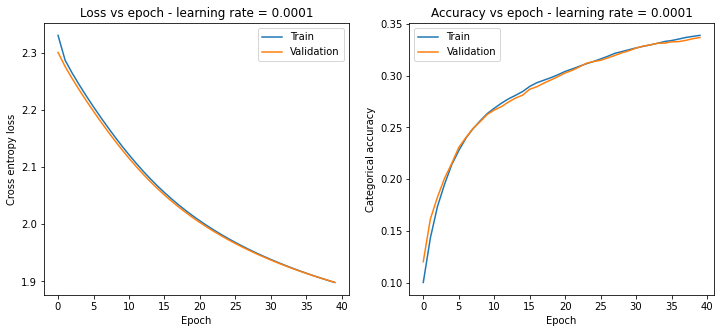

In [50]:
SGD_model_2 = SGD(40, 0.0001)

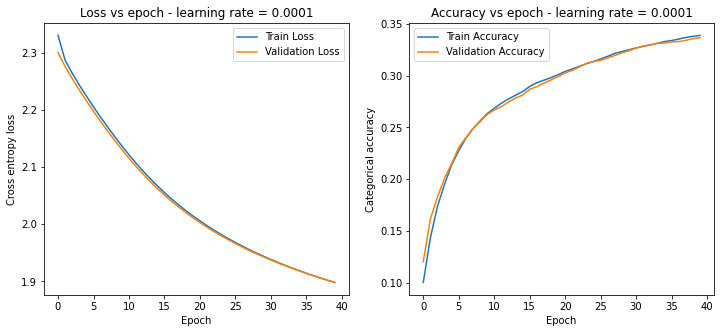

In [119]:
# Plot graphs of epoch vs loss and accuracy for training and validation dataset
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(SGD_model_2[0], label='Train Loss')
plt.plot(SGD_model_2[2], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch - learning rate = 0.0001")
plt.legend()

fig.add_subplot(122)
plt.plot(SGD_model_2[1], label='Train Accuracy')
plt.plot(SGD_model_2[3], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch - learning rate = 0.0001")
plt.legend()

plt.show()

#### Analysis

Observing now the graphs for the model with learning rate 0.0001, it is apparent that there is significantly less overfitting within the model compared to that of 1.1.1 with learning rate 0.01. The losses and accuracies appear to start to converge faster than before by epoch 40, however the actual losses reached are higher than before, reaching almost 1.9. Similarly, the accuracies have peaked at almost 35% at epoch 40, which is much less than with the higher learning rate. This represents the balance between capacity and generalisation.

This lower learning rate has allowed a much more generalised model, which will not have significant overfitting and hence the validation data will match the training data - however as a consequence, the resulting losses will be higher and accuracies will be lower, compared to that of a higher learning rate.

Epoch 1
Training Loss 2.1936991394654446
Training Accuracy 0.25548878205128206
Validation Loss 1.8806343021133376
Validation Accuracy 0.30478766025641024
Epoch 2
Training Loss 1.7954896841904249
Training Accuracy 0.3567508012820513
Validation Loss 1.8353428495899538
Validation Accuracy 0.3267227564102564
Epoch 3
Training Loss 1.6983409501487687
Training Accuracy 0.39224759615384613
Validation Loss 1.7084688603998204
Validation Accuracy 0.3815104166666667
Epoch 4
Training Loss 1.6315735438364394
Training Accuracy 0.41684695512820513
Validation Loss 1.6468986989322958
Validation Accuracy 0.4046474358974359
Epoch 5
Training Loss 1.5773993927406085
Training Accuracy 0.43691907051282053
Validation Loss 1.6074629626772903
Validation Accuracy 0.418369391025641
Epoch 6
Training Loss 1.5312616923329398
Training Accuracy 0.45318509615384617
Validation Loss 1.5822052638455917
Validation Accuracy 0.4310897435897436
Epoch 7
Training Loss 1.4902213270305875
Training Accuracy 0.46953125
Validation Lo

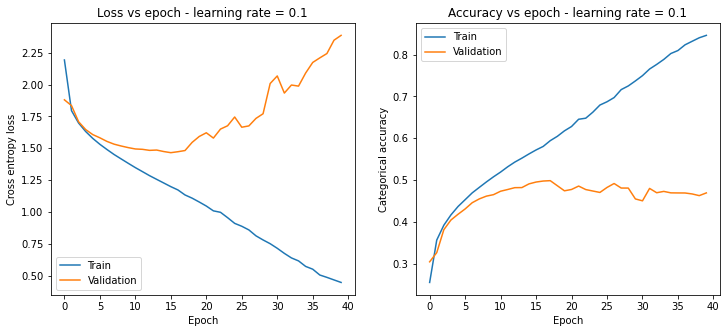

In [51]:
SGD_model_3 = SGD(40, 0.1)

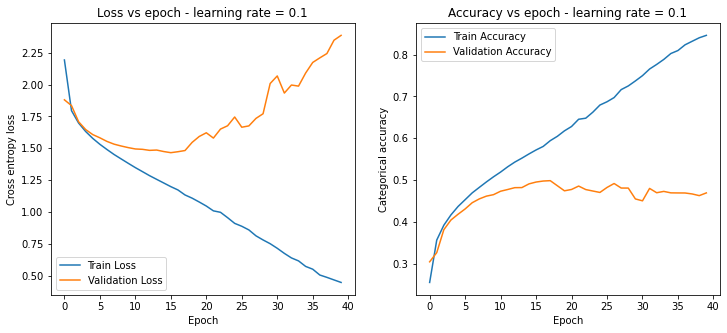

In [120]:
# Plot graphs of epoch vs loss and accuracy for training and validation dataset
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(SGD_model_3[0], label='Train Loss')
plt.plot(SGD_model_3[2], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch - learning rate = 0.1")
plt.legend()

fig.add_subplot(122)
plt.plot(SGD_model_3[1], label='Train Accuracy')
plt.plot(SGD_model_3[3], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch - learning rate = 0.1")
plt.legend()

plt.show()

#### Analysis

Here we have the plots for a learning rate of 0.1. Evidently the training loss appear to have become linear at a much earlier epoch than with the learning rate of 0.01, at approximately epoch 5. However the validation loss indicates significant overfitting within the model, since it reaches a minimum at approximately epoch 15 and diverges from the training loss entirely. It does not appear to converge to any loss as it continues to increase.

The performance of the model however has also changed, since the training accuracies appear to have risen from the plots of 1.1.1, with the training accuracy reaching almost 85% at epoch 40 but the validation accuracy plateauing at 47%.

Evidently in this case, we have far more capacity than generalisation compared to 1.1.1 since we have overfitting but higher accuracies. This is because the model has been overtrained, since the model has rather memorised the training data as opposed to learning from it, hence low validation accuracies and high validation losses.

#### 1.1.3

Now we look to train the original neural network from 1.1.1 for 80 epochs instead of 40 epochs:

In [57]:
SGD_model_4 = SGD(80, 0.01)

Epoch 1
Training Loss 1.9498853796551185
Training Accuracy 0.3028445512820513
Validation Loss 1.8393982042356014
Validation Accuracy 0.3495592948717949
Epoch 2
Training Loss 1.794906855252174
Training Accuracy 0.36638621794871795
Validation Loss 1.7841381582924607
Validation Accuracy 0.3574719551282051
Epoch 3
Training Loss 1.737874842060619
Training Accuracy 0.38635817307692305
Validation Loss 1.7380296372732074
Validation Accuracy 0.3742988782051282
Epoch 4
Training Loss 1.692468632830625
Training Accuracy 0.40392628205128206
Validation Loss 1.698965531083868
Validation Accuracy 0.3883213141025641
Epoch 5
Training Loss 1.6543941867632395
Training Accuracy 0.4166666666666667
Validation Loss 1.6676312277075112
Validation Accuracy 0.40384615384615385
Epoch 6
Training Loss 1.622888418839049
Training Accuracy 0.4260817307692308
Validation Loss 1.641043881920894
Validation Accuracy 0.41516426282051283
Epoch 7
Training Loss 1.5963990765055915
Training Accuracy 0.4345152243589744
Validation 

Training Loss 1.022941759158156
Training Accuracy 0.6399238782051282
Validation Loss 1.3750601942329006
Validation Accuracy 0.5271434294871795
Epoch 56
Training Loss 1.0126879382824248
Training Accuracy 0.6440504807692308
Validation Loss 1.3788562304900946
Validation Accuracy 0.5268429487179487
Epoch 57
Training Loss 1.0023916379669244
Training Accuracy 0.6482171474358974
Validation Loss 1.383284539334937
Validation Accuracy 0.5274439102564102
Epoch 58
Training Loss 0.9920551710031091
Training Accuracy 0.65234375
Validation Loss 1.388329262064004
Validation Accuracy 0.5256410256410257
Epoch 59
Training Loss 0.9816811617664988
Training Accuracy 0.6569711538461539
Validation Loss 1.3939415868578198
Validation Accuracy 0.5245392628205128
Epoch 60
Training Loss 0.9712719102133945
Training Accuracy 0.6608573717948718
Validation Loss 1.4000359510601987
Validation Accuracy 0.5250400641025641
Epoch 61
Training Loss 0.960828403461264
Training Accuracy 0.665244391025641
Validation Loss 1.4064947

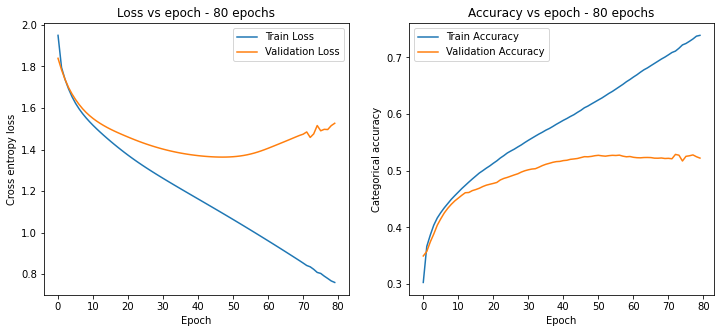

In [121]:
# Plot graphs of epoch vs loss and accuracy for training and validation dataset
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(SGD_model_4[0], label='Train Loss')
plt.plot(SGD_model_4[2], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch - 80 epochs")
plt.legend()

fig.add_subplot(122)
plt.plot(SGD_model_4[1], label='Train Accuracy')
plt.plot(SGD_model_4[3], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch - 80 epochs")
plt.legend()

plt.show()

#### Analysis

Here we observe that training the model for 80 epochs has yielded particularly interesting results. In comparison to 1.1.1, we see that the training loss and accuracy has continued to decrease/increase in a linear fashion towards 0.9 and 69% respectively after 80 epochs. On the other hand, the validation loss has started to increase once again past 50 epochs, demonstrating significantly more overfitting than before, also evident from how the validation accuracy has appeared to plateau at just above 50%. This can be explained since running the model for double the epochs will make the model see each data point twice as much, and hence the parameters become overtrained on the training data too much and hence will begin to 'memorise' the data as opposed to learn and generalise.

Compared to the learning rate of 0.0001 in 1.1.2, we observe hardly any similarities at all. There is significantly more overfitting in this graph compared to the negligible overfitting of the LR = 0.0001 graph, and achieves much higher accuracies also. Once again, this is explained since both a higher number of epochs and higher learning rate will leave the model more prone to overfitting, but with higher accuracies. This is because not only will the training algorithm see each data point double the number of times, but also the higher learning rate leads to each batch having a greater impact on the model, and hence decreases the chance of convergence.

In comparison to the learning rate of 0.1 however, we notice that the graphs are in fact very similar in shape, despite both models being trained over a different number of epochs with a different learning rate. Both graphs appear to display significant overfitting, with high divergences in training and validation data. This is explained by the fact that the effect of a lower learning rate will balance the effect of a higher number of epochs will lead towards opposing outcomes; a lower learning rate will lead the model towards generalisation instead of capacity, whereas more epochs will lead the model towards capacity over generalisation. The former occurs because a lower learning rate will reduce the impact of each batch and increase the increase the rate of convergence. The latter occurs because more epochs leads to memorisation over learning for the model.

### Question 1.2 - Convolutional Neural Networks (CNN)

#### 1.2.1 - Using TensorFlow

In this section, we look to implement a convolutional neural network (CNN) using TensorFlow, with the following architecture:

* Four hidden layers with ReLU activation function
  * 3 Convolutional layers first
  * 1 fully-connected layer last
* All convolutional layers apply 3x3 feature maps
  * First uses 32 feature maps
  * Last 2 use 64 feature maps
* 2x2 maximum pooling layers between convolutional layers
* Fully-connected layer has 64 neurons
* Output layer has 10 neurons with softmax activation function
* Optimisation method = Stochastic gradient descent (SGD)
* Loss function = Categorical cross-entropy

In [122]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2, l1

We aim to train the model on the CIFAR-10 dataset once again, using batches of 128 data points and a learning rate of 0.1 for 40 epochs.

In [123]:
# Retrieve training data of inputs and outputs
train_data = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
# Shuffle the dataset
train_data = train_data.shuffle(50000)
# Create batches of size 128
train_data = train_data.batch(128)
# Retrieve validation data of inputs and outputs
val_data = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))
# Create batches of size 128
val_data = val_data.batch(128)
# Define SGD optimiser with learning rate 0.1
SGD = tf.keras.optimizers.SGD(learning_rate=0.1)

We first define our model implementing the architecture from above, noting that our input data will be images with resolution 32x32 and 3 colour channels, hence the input shape is 32x32x3. Since we aim to plot the accuracy of the model, we want to compile model whilst tracking the accuracy of each epoch.

In [124]:
def get_model_1():
    model_1 = Sequential([
        # 3 hidden convolutional layers with ReLU activation and max pooling layers
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        # Flatten the dimensions since we have multidimensional inputs
        Flatten(),
        # Hidden fully-connected layer with 64 neurons and ReLU activation
        Dense(64, activation='relu'),
        # Output layer with 10 neurons and softmax activation
        Dense(10, activation='softmax')
    ])
    # Compile the model with custom SGD
    model_1.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model_1

We can retrieve the model as follows, and generate a summary to confirm our output shapes are correct

In [125]:
model_1 = get_model_1()
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

Now we aim to use this architecture to train the model on the training data set of 50000 images. We run the training for 40 epochs

In [126]:
def train_model(model):
    history = model.fit(train_data, epochs=40, verbose=1, validation_data=val_data)
    return history

In [128]:
history_1 = train_model(model_1)

Epoch 1/40
391/391 [==============================] - 21s 52ms/step - loss: 2.1723 - accuracy: 0.1933 - val_loss: 1.7895 - val_accuracy: 0.3503
Epoch 2/40
391/391 [==============================] - 22s 56ms/step - loss: 1.6746 - accuracy: 0.4025 - val_loss: 1.5356 - val_accuracy: 0.4389
Epoch 3/40
391/391 [==============================] - 22s 55ms/step - loss: 1.4302 - accuracy: 0.4886 - val_loss: 1.2878 - val_accuracy: 0.5369
Epoch 4/40
391/391 [==============================] - 22s 55ms/step - loss: 1.2751 - accuracy: 0.5490 - val_loss: 1.4747 - val_accuracy: 0.4943
Epoch 5/40
391/391 [==============================] - 23s 57ms/step - loss: 1.1796 - accuracy: 0.5863 - val_loss: 1.1164 - val_accuracy: 0.6043
Epoch 6/40
391/391 [==============================] - 22s 56ms/step - loss: 1.0872 - accuracy: 0.6162 - val_loss: 1.0928 - val_accuracy: 0.6144
Epoch 7/40
391/391 [==============================] - 23s 58ms/step - loss: 1.0145 - accuracy: 0.6446 - val_loss: 1.0891 - val_accuracy:

Now that we have successfully trained the model, we can plot the graphs of epoch versus loss and accuracy for both the training and validation data as follows:

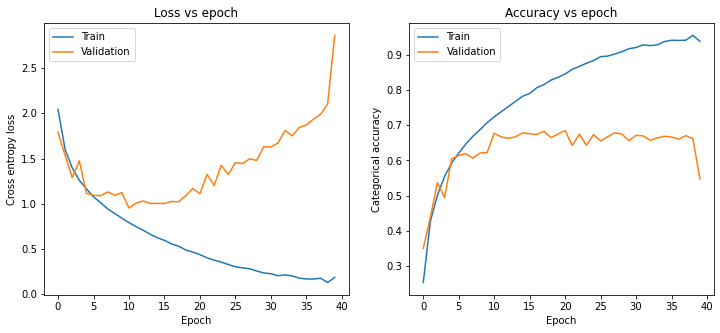

In [129]:
# Plot graphs of epoch vs loss and accuracy for training and validation dataset
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_1.history['loss'], label='Train')
plt.plot(history_1.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(122)
plt.plot(history_1.history['accuracy'], label='Train')
plt.plot(history_1.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()

plt.show()

#### Analysis

From these graphs, we can deduce that the training data's loss and accuracy appear to converge, alongside the validation data's accuracy to a value. The training accuracy appears to approach approximately 95%, the validation accuracy approaching 67% after plateauing after 10 epochs, and the training loss approaching 0.17. Overall, these values appear to converge very slowly, only reaching a plateau only by the 40th epoch for the training data, and plateauing at approximately the 10th epoch for the validation accuracy (although this is simply due to the overfitting of the model).

However the validation loss doesnt appear to converge after 40 epochs, as it is continuing to increase and is a significant indicator of overfitting in the model. After 10 epochs, the validation loss appears to reach a minimum but then continues to increase without a sign of plateauing. This means there is overfitting within the model, perhaps due to the model being greatly overparameterised.

#### 1.2.2 - L2 Regularisation

Now we look to improve the model using an L2 kernel regulariser in all the convolutional layers and plot the graphs of loss and accuracy once again. We use a L2 parameter of 0.005, and we aim to reducing the overfitting of the model as we observed above with the unregularised model.

In [130]:
def get_model_2():
    model_2 = Sequential([
        # 3 hidden convolutional layers, now including l2 regularizer, with ReLU activation and max pooling layers     
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(5e-3), input_shape=(32, 32, 3)),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(5e-3)),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(5e-3)),
        # Flatten the dimensions since we have multidimensional inputs
        Flatten(),
        # Hidden fully-connected layer with 64 neurons and ReLU activation
        Dense(64, activation='relu'),
        # Output layer with 10 neurons and softmax activation
        Dense(10, activation='softmax')
    ])
    # Compile the model with custom SGD
    model_2.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model_2

model_2 = get_model_2()

history_2 = train_model(model_2)

Epoch 1/40
391/391 [==============================] - 33s 83ms/step - loss: 2.6704 - accuracy: 0.1880 - val_loss: 2.1260 - val_accuracy: 0.3183
Epoch 2/40
391/391 [==============================] - 33s 84ms/step - loss: 2.0883 - accuracy: 0.3486 - val_loss: 1.8387 - val_accuracy: 0.4145
Epoch 3/40
391/391 [==============================] - 32s 80ms/step - loss: 1.8027 - accuracy: 0.4225 - val_loss: 1.5917 - val_accuracy: 0.4835
Epoch 4/40
391/391 [==============================] - 32s 82ms/step - loss: 1.6510 - accuracy: 0.4681 - val_loss: 1.6530 - val_accuracy: 0.4715
Epoch 5/40
391/391 [==============================] - 33s 85ms/step - loss: 1.5903 - accuracy: 0.4918 - val_loss: 1.5287 - val_accuracy: 0.5225
Epoch 6/40
391/391 [==============================] - 34s 86ms/step - loss: 1.5035 - accuracy: 0.5280 - val_loss: 1.5650 - val_accuracy: 0.5088
Epoch 7/40
391/391 [==============================] - 35s 89ms/step - loss: 1.4571 - accuracy: 0.5487 - val_loss: 1.4865 - val_accuracy:

Again, we look to plot the graphs of epoch vs loss and accuracy for training and validation dataset:

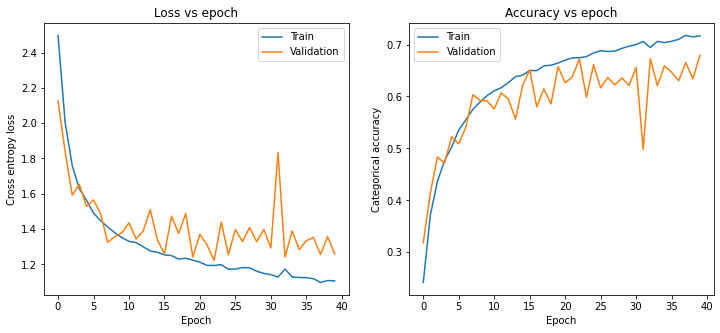

In [131]:
# Plot graphs of epoch vs loss and accuracy for training and validation dataset
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_2.history['loss'], label='Train')
plt.plot(history_2.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(122)
plt.plot(history_2.history['accuracy'], label='Train')
plt.plot(history_2.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()

plt.show()

#### Analysis

Here we observe a significant difference to the previous plots, now that we have included an L2 regulariser (coefficient $5\cdot 10^{-3}$) in all three convolutional layers.

Compared to 1.2.1, the training loss appears to converge to a higher value of approximately 1.1, with the validation loss behaving more noisily - however with much less overfitting since the validation loss is not too dissimilar from the training loss. The training accuracy appears to have converged to a lower value of approximately 71%, as well as the validation accuracy falling to around 64% from 1.2.1. Therefore it is apparent that although there is significantly less overfitting, there is still some noticeable differences in the training and validation results. The rate of convergence is also noticeably faster, compared to that of 1.2.1.

Evidently, L2 regularisation has in one sense improved the training procedure by significantly reducing the overfitting of the model. However in turn, it has increased the training loss and decreased both accuracies. L2 regularisation functions by adding a cost to the loss function proportional to the square of the value of the weights coefficients. Since our coefficient is very small ($5\cdot10^{-3}$), this forces the parameters that could be updated to be something large to be penalised and reupdated back to a small value. This successfully makes the model more resistant to overfitting since it will not be parameterised by large values, hence the losses will remain small as any large parameter will be regularised and small again. However on the other hand, by regularising the weights and stopping them from becoming too large, this will in turn restrict the capacity of the network and explains the lower training and validation accuracies obtained.

#### 1.2.3 - L1 Regularisation and Dropout

Now I aim to implement two other methods to improve the performance of the training procedure.

Firstly, I aim to use an L1 regulariser with the same coefficient as the L2 coefficient of 0.005 as follows:

In [132]:
def get_model_3():
    model_3 = Sequential([
        # 3 hidden convolutional layers, now including l1 regularizer, with ReLU activation and max pooling layers
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1(5e-3), input_shape=(32, 32, 3)),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1(5e-3)),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1(5e-3)),
        # Flatten the dimensions since we have multidimensional inputs
        Flatten(),
        # Hidden fully-connected layer with 64 neurons and ReLU activation
        Dense(64, activation='relu'),
        # Output layer with 10 neurons and softmax activation
        Dense(10, activation='softmax')
    ])
    # Compile the model with custom SGD
    model_3.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model_3

model_3 = get_model_3()

history_3 = train_model(model_3)

Epoch 1/40
391/391 [==============================] - 33s 83ms/step - loss: 6.2643 - accuracy: 0.1577 - val_loss: 2.2089 - val_accuracy: 0.2460
Epoch 2/40
391/391 [==============================] - 33s 82ms/step - loss: 2.2202 - accuracy: 0.2423 - val_loss: 2.0989 - val_accuracy: 0.2924
Epoch 3/40
391/391 [==============================] - 33s 83ms/step - loss: 2.1483 - accuracy: 0.2719 - val_loss: 2.1056 - val_accuracy: 0.2805
Epoch 4/40
391/391 [==============================] - 32s 82ms/step - loss: 2.0983 - accuracy: 0.2914 - val_loss: 2.0401 - val_accuracy: 0.3210
Epoch 5/40
391/391 [==============================] - 33s 82ms/step - loss: 2.0603 - accuracy: 0.3085 - val_loss: 2.0361 - val_accuracy: 0.3266
Epoch 6/40
391/391 [==============================] - 33s 85ms/step - loss: 2.0404 - accuracy: 0.3171 - val_loss: 2.0011 - val_accuracy: 0.3415
Epoch 7/40
391/391 [==============================] - 33s 84ms/step - loss: 2.0209 - accuracy: 0.3270 - val_loss: 2.0285 - val_accuracy:

Again, we look to plot the graphs of epoch vs loss and accuracy for training and validation dataset:

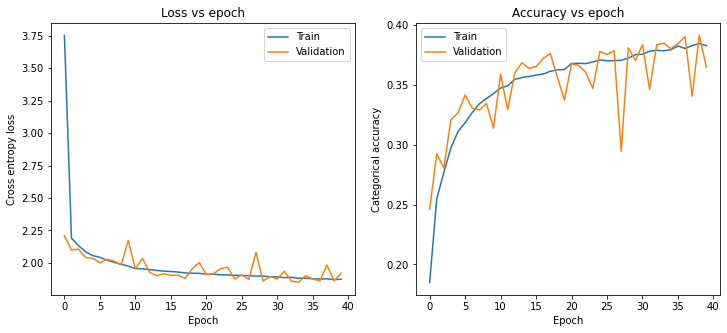

In [133]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_3.history['loss'], label='Train')
plt.plot(history_3.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(122)
plt.plot(history_3.history['accuracy'], label='Train')
plt.plot(history_3.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()

plt.show()

#### Analysis

Implementing L1 regularisation appears to completely reduce the overfitting of the model from the unregularised model in 1.2.1, since there is no divergence between the training and validation losses, and the training and validation accuracies are much more closely matched, although the trade-off is that the accuracies have become significantly lower than the model in 1.2.1. The rate of convergence is also significantly faster than in 1.2.1, reaching its plateau even perhaps by epoch 5 or 10 for the losses.

The reduction of overfitting in the model is due to the L1 regulariser (similarly to L2) ensuring that the parameters within the model do not become too large by adding a cost proportional to the absolute value of the weights coefficients. This encourages a sparse model since weights are therefore pushed towards exactly zero, as opposed to L2 regularisation which forces parameters to only become small since the penalty becomes smaller instead for smaller weights. This explains why compared to L2 regularisation, the cross entropy losses for both the training and validation datasets have converged to a higher loss than in L2 at around 1.85.

Similarly, the accuracy is also noticeably lower than L2 for both datasets, converging at around 38%. This may be because the parameters have been reduced significantly more than even L2, and so despite the parameters becoming low and preventing overfitting, the actual accuracy of the model is lost since the capacity of the network has been restricted. However it is worth noting that despite a higher loss and lower accuracy, both datasets are very closely matched which indicates effectively no overfitting within the model, an improvement in that sense compared to L2 regularisation. However despite having a more generalised model, we lose capacity in the network and hence accuracy.

Next, I aim to implement Dropout with a rate of 0.5, to help reduce overfitting. We can do this by adding Dropout after the fully-connected layer as follows:

In [134]:
def get_model_4():
    model_4 = Sequential([
        # 3 hidden convolutional layers with ReLU activation and max pooling layers
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        # Flatten the dimensions since we have multidimensional inputs
        Flatten(),
        # Hidden fully-connected layer with 64 neurons and ReLU activation
        Dense(64, activation='relu'),
        # Dropout layer with rate 0.5
        Dropout(0.5),
        # Output layer with 10 neurons and softmax activation
        Dense(10, activation='softmax')
    ])
    # Compile the model with custom SGD
    model_4.compile(loss='categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model_4

model_4 = get_model_4()

history_4 = train_model(model_4)

Epoch 1/40
391/391 [==============================] - 33s 83ms/step - loss: 2.2384 - accuracy: 0.1518 - val_loss: 1.8176 - val_accuracy: 0.3538
Epoch 2/40
391/391 [==============================] - 32s 82ms/step - loss: 1.8770 - accuracy: 0.3162 - val_loss: 1.5920 - val_accuracy: 0.4268
Epoch 3/40
391/391 [==============================] - 33s 84ms/step - loss: 1.6494 - accuracy: 0.4074 - val_loss: 1.4059 - val_accuracy: 0.4919
Epoch 4/40
391/391 [==============================] - 33s 83ms/step - loss: 1.5035 - accuracy: 0.4605 - val_loss: 1.3187 - val_accuracy: 0.5208
Epoch 5/40
391/391 [==============================] - 33s 82ms/step - loss: 1.4020 - accuracy: 0.4936 - val_loss: 1.2430 - val_accuracy: 0.5560
Epoch 6/40
391/391 [==============================] - 33s 82ms/step - loss: 1.3163 - accuracy: 0.5372 - val_loss: 1.1744 - val_accuracy: 0.5845
Epoch 7/40
391/391 [==============================] - 33s 84ms/step - loss: 1.2507 - accuracy: 0.5601 - val_loss: 1.1213 - val_accuracy:

Again, we look to plot the graphs of epoch vs loss and accuracy for training and validation dataset:

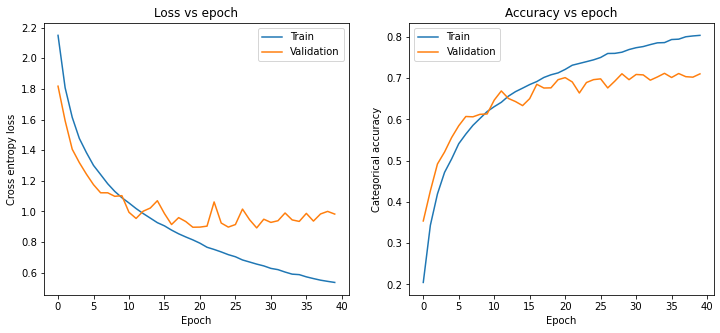

In [135]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(history_4.history['loss'], label='Train')
plt.plot(history_4.history['val_loss'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()

fig.add_subplot(122)
plt.plot(history_4.history['accuracy'], label='Train')
plt.plot(history_4.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()

plt.show()

Including a Dropout layer appears to have reduced overfitting within the model, compared to the unregularised model in 1.2.1, since we observe that the validation loss has not increased to the same amount as in 1.2.1. The training loss is higher than that of 1.2.1, and the training accuracy approaches 80% which is lower than the 95% of 1.2.1, whereas the validation accuracy is very similar. 

This reduction in overfitting can be explained by the nature of the dropout algorithm. The implementation of dropout involves specifying the probability (0.5) at which outputs of the dense layer are retained. This however causes the weights of the model to increase, however to compensate for this, the weights are rescaled down by the given dropout rate. This has a similar effect to a kernel regulariser, since the weights are prevented from becoming too big and hence overfitting is lessened. This will naturally in turn cause a restriction of the capacity of the model, since parameters are kept small and hence the accuracies will be lower than the unregularised model.

Observing the graphs after implementing Dropout with a rate of 0.5, we observe that there appears to be more overfitting within the model compared to L2 regularisation since the validation loss begins to rise past its minimum at approximately epoch 20-25. That being said, some improvements to L2 can be observed since the training loss is much lower, approaching almost 0.5 and also the graphs appear less noisy for all 4 curves. The accuracies attained for Dropout are also significantly higher, reaching above 80% for training and 70% for validation.

#### 1.2.4 - Comparison with MLP in 1.1.1

We now look to compare the results obtained with the MLP in 1.1.1 with the results from the CNN with Dropout in 1.2.3.

First we can compare the accuracies of both models. Evidently, the training and validation accuracies obtained for the CNN with Dropout are much higher than that of the MLP, obtaining 81% training and 70% validation accuracies - much higher than the 60% training and 50% validation accuracies of the MLP. This increase in accuracy can be explained by the use of local connectivity to build on the framework of the MLP architecture, because instead of individual pixels and colour channels being inputted into a neural network like MLP, we allow each neuron to receive inputs from a local group of pixels from the image and hence the network is trained on larger structures and patterns as opposed to individual pixels. This allows for much more effective objection detection, and hence a more accurate classification for the input images compared to MLP.

Next we can compare the computational time for training of both models. For the MLP model, the training lasted 40 minutes for 40 epochs, whereas the CNN with Dropout training lasted 23 minutes. This is not a large difference, especially since these durations varied a lot on different runs of my code, but is still a noticeable difference. This is most likely largely due to CNN having to update far fewer parameters than in MLP. However from this reason I would expect a much larger difference in training duration. Perhaps also, for CNN the inputs are unflattened rank 3 tensors and hence higher dimensional matrix multiplication is a slightly more costly than 2D matrix multiplication on flattened data. However this is not much of a compensation for having 15x fewer parameters compared to MLP.

Lastly, the number of parameters in the model varied significantly. The CNN model with Dropout had 122,570 trainable parameters, whereas the MLP model has 1,877,482 trainable parameters via the Glorot initialisation. This occurs because MLP involves fully connected layers, where each neuron is connected to the others which can lead to redundancy. CNN however revolves around parameter sharing, since the algorithm looks for local patterns and combinations of pixels, particularly useful for object detection within images, as explored previously.

## Task 2: Unsupervised learning

### Question 2.1 - Clustering of the feature matrix

First we look to import our feature matrix dataset as follows. I've used pandas to import the data, in order to remove the first row and column of the dataset. Also we can normalise the data since we have 100 different features, in order to better represent the values of each feature.

In [136]:
F = pd.read_csv('feature_matrix_karate_club.csv', header= None)
X = F.values[1:,1:]

def normalise(X):
    
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

X = normalise(X)

#### 2.1.1 - K-means algorithm

Now we aim to employ the k-means algorithm to cluster the feature matrix. I plan to optimise the clusterings by setting 100 different random initial seeds for the cluster labels, to then employ the k-means algorithm to adjust these labels through the function below, for a given number of clusters $k$.

I can then calculate and output the within-cluster distances $W(C)$ for 100 different initialisations for a given $k$ using the Euclidean distance measure (i.e. the $L^2$ norm), before plotting its graph for $k$ in the interval $[2, 10]$.

In [137]:
def k_means(k):
    
    # Calculate shape of dataset
    n_samples, n_features = X.shape
    # Set upper limit on number of iterations, to ensure algorithm has a stopping mechanism
    max_iter = 15
    # Initialise variables for the updated labels, within distance and size of each cluster
    new_labels = np.zeros(len(X))
    Wbar = 0
    nk = np.zeros(k)
    # Set number of initial random seeds
    num_init = 100
    # Pre allocate vector which stores W values across 100 initialisations
    W_store = np.zeros(num_init)

    for s in range(num_init):
        np.random.seed(4*s)
        # labels: assign every sample to a cluster at random
        labels = np.random.randint(low=0, high=k, size=n_samples)
        # Algorithm to ensure every label is used at least once
        min_1_label = np.random.choice(n_samples,k,replace=False)
        for r in range(k):
            labels[min_1_label[r]] = r
        X_labels = np.append(X, labels.reshape(-1,1), axis=1)

        # computing the centroids of each of the k clusters
        centroids = np.zeros((k, n_features))
        for i in range(k):   
            centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]
            
        # k-means algorithm
        for i in range(max_iter):
            
            # distances: between data points and centroids
            distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
            # new_labels: computed by finding centroid with minimal distance
            new_labels = np.argmin(distances, axis=0)

            if (labels==new_labels).all():
                # labels unchanged
                labels = new_labels
                # Calculate within distance
                W = np.sum(np.ndarray.min(np.square(distances), axis=0))
                # Store W values
                W_store[s] = W
                break
            else:
                # labels changed
                labels = new_labels
                for c in range(k):
                    # update centroids by taking the mean over associated data points
                    if (labels == c).any():
                        centroids[c] = np.mean(X[labels==c], axis=0)
    
    return W_store, labels

# Create k means function which only outputs W, in order to easily vectorise and plot
def k_means_W(k):
    W_store = k_means(k)[0]
    Wbar = np.mean(W_store)
    return Wbar

# Vectorise the k means function
k_means_W_vec = np.vectorize(k_means_W, cache=True)

Below is the plot of $k$ against the within-cluster distance from the k-means algorithm, for values of $k$ between 2 and 10.

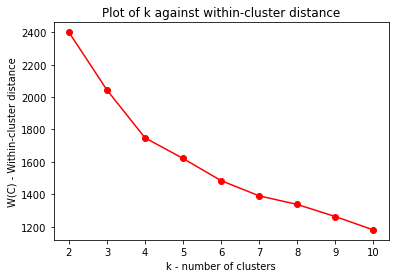

In [138]:
# Create range of k values to plot against within distance
k_val = np.arange(2, 11)
W_val = k_means_W_vec(k_val)
plt.plot(k_val, W_val, '-ro')
plt.xlabel('k - number of clusters')
plt.ylabel('W(C) - Within-cluster distance')
plt.title('Plot of k against within-cluster distance');

#### Analysis - Choosing an optimal clustering

We observe that this graph is decreasing as $k$ increases. In addition, the rate of decrease appears to decrease as $k$ increases, which indicates that there may be a value of $k$ which gives an optimal clustering for this dataset via the elbow method. 

It appears as if by about $k = 4$, the rate of decrease becomes constant and hence any increase in $k$ does not offer any more of a decrease in $W(C)$ than the previous increment. Therefore from this graph, it is suggested that an optimal clustering for this dataset is obtained at $k = 4$, since the graph appears somewhat linear from $k=4$ onwards.

It must be noted however that there is still no obvious elbow in this graph, which may be indicative of the fact that perhaps clustering the dataset may not be very meaningful if the data is relatively spread and so the clusters created may not be clear and distinct. In other words, even if $k=4$ is the optimal number of clusters, it may not be optimal by a large extent. Nevertheless, we still deduce that $k=4$ gives the optimal clustering for this dataset by analysing the within-cluster distances.

#### 2.1.2 - Calinski-Harabasz (CH) score

Now we aim to implement the Calinski-Harabasz (CH) score in order to identify a value of $k$ which provides an optimal clustering according to the CH score rather than the within-cluster distance measure in the previous section.

The CH score takes into account a ratio of the between and within cluster distances ($B_k$ and $W_k$ respectively), alongside the degrees of freedom of both measures through the following equation:

$$
CH_k = \frac{B_k}{W_k} \cdot \frac{N-k}{k-1}
$$

where $B_k = TSS - W_k$ and $W_k = \sum_{i=1}^k \sum_{j=1}^{n_i} ||x^{(i)} - c_i||^2$, where $TSS$ is the total sum of squares such that $TSS = \sum_{i=1}^{N} ||x^{(i)} - c||^2$ with $c$ as the global centroid and $N$ as the number of samples in the dataset. (Source: https://ethen8181.github.io/machine-learning/clustering_old/clustering/clustering.html, Accessed: 15/03/2021)

In [139]:
def CH_score(k):   
    
    # Calculate number of samples N of dataset
    n_samples = X.shape[0]
    # Retrieve W values from k-means algorithm for each of the 100 initialisations
    W_store = k_means(k)[0]
    # Calculate global centroid as mean of all samples
    global_c = np.mean(X, axis=0)
    # Calculate Total Sum of Squares of dataset
    TSS = np.sum(np.square(X - global_c))
    # Calculate between-cluster distances
    B_store = TSS - W_store
    # Calculate CH score from above formula
    CHk = np.divide(B_store, W_store) * ((n_samples-k)/(k-1))
    return CHk, W_store, B_store

def CH_score_bar(k):
# Calculate mean of all CH scores from 100 initialisations
    CHk_bar = np.mean(CH_score(k)[0])
    return CHk_bar

# Vectorise function to allow vector inputs, in order to plot on a graph
CH_score_vec = np.vectorize(CH_score_bar, cache=True)

Below we can plot the CH score as a function of increasing $k$ in the interval $[2,10]$.

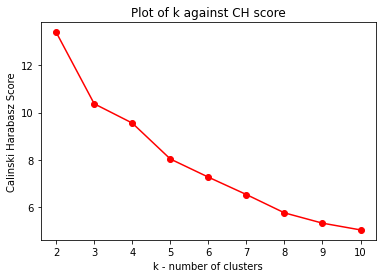

In [140]:
# Create range of k values to plot against CH score
k_val = np.arange(2, 11)
plt.plot(k_val, CH_score_vec(k_val), '-ro')
plt.xlabel('k - number of clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('Plot of k against CH score');

#### Analysis - Choosing an optimal clustering

From this plot, we observe that $k=2$ achieves the highest value for the CH score, hence we could conclude that $k=2$ gives the optimal clustering according to the CH score. This is because the CH score is an indicator of how dense and well separated the clusters are; the higher the score the better. The CH score is essentially a ratio between the between cluster distance and the within cluster distance, as indicated by the formula. For well defined clusters, we require a high between cluster distance for clusters to be well spread out, and a low within cluster distance for clusters to be dense. Hence the ratio $\frac{B_k}{W_k}$ takes both values into account, with a high CH-score indicating both distances are optimised.

However the graph appears somewhat linear, which may indicate that even though $k=2$ achieves the highest CH score, there is not much of a noticeable decrease in score for $k=3$ for example, and therefore there is not a significant difference in using 3 clusters compared to 2, and similarly for subsequent values of $k$.

Although this observation doesn't change the conclusion that the optimal clustering uses $k=2$ clusters according to the CH score, it may indicate that these clusters are not particularly clear or well defined.

#### 2.1.3 - Evaluation of Robustness of clusterings

In this section, we aim to evaluate the robustness of the clusterings from the k-means algorithm in 2.1.1 as a function of k. We define the 'robustness' of clusterings as a measure of both how dense and spread out the clusters are - this is what the CH-score measures, as discussed in 2.1.2. The CH-score is high for clusters with centroids which are distant from each other and with samples in each cluster being close together, hence the CH-score is a strong indicator of robustness.

However, it is important to consider that different intialisations of the labels may produce different clusterings of the feature matrix and therefore even though we have taken a mean of the CH score over 100 initialisations, we know nothing about the consistency or variability of these clusterings. We can now analyse the variance, and thus the standard error $(SE = \frac{\sigma}{\sqrt{N}})$ of the CH scores across 100 initialisations and plot the standard error bars for each value of k.

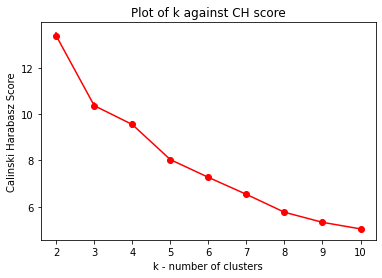

In [141]:
# Calculate variance of CH score from 100 initialisations
def CHk_var(k):
    CHk_var = np.var(CH_score(k)[0])
    return CHk_var

# Vectorise variance function
CHk_var_vec = np.vectorize(CHk_var, cache=True)

# Create range of k values to calculate standard error
k_val = np.arange(2, 11)
error = np.sqrt(CHk_var_vec(k_val)/100)

plt.errorbar(k_val, CH_score_vec(k_val), yerr = error, fmt='-ro')
plt.xlabel('k - number of clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('Plot of k against CH score');

#### Analysis

Evidently, the error bars are hard to even identify on the graph since the standard error is so small, due to the large number of initialisations we choose $(N = 100)$. Hence, the variability of the CH-score is negligible and therefore the clusterings obtained from the k-means algorithm across 100 initialisations are also consistent since the CH-scores are mostly consistent for each initialisation. This indicates that we can rely on the CH-score as an indicator for the optimal $k$ which provides the most robust clustering, and hence we can deduce $k=2$ as the optimal clustering of the dataset from the analysis of 2.1.2, since we know the CH-score measures the robustness of the dataset. 

It is however still vital to note once again, that despite obtaining the optimal clustering of the feature matrix according to CH-score i.e the value of $k$ resulting in the most robust clustering, this may not imply that the clustering is robust in itself in an absolute sense. A peak CH-score of approximately 13 is still very low compared to other datasets, for example the data in the Clustering notebook which obtains a CH-score of over 500. 

### Question 2.2 - Dimensionality reduction of the feature matrix

#### 2.2.1 - Principal Component Analysis (PCA)

In this section, we aim to employ Principal component analysis (PCA) on the feature matrix to output a lower dimensional projection of the dataset, so that we can easily visualise the data. Since our feature matrix is 100-dimensional, we of course cannot plot a graph however by breaking down the dataset into its 'principal components', we can create 1-d, 2-d and 3-d projections of the data and graph them.

In order to perform PCA on our feature matrix for a given number of principal components $k$, we need to implement the following algorithm:

1. Compute the covariance matrix  $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
4.  Compute the projection onto the spaced spanned by the top $n$ eigenvectors.

This has been implemented through the code below:

In [142]:
from scipy.sparse import linalg

def pca_function(X,k):

    # Create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # Compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 
    
    # Sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index ]
    
    # Algorithm to ensure first value of each eigenvector is positive
    for i in range(k):
        if eigenvectors[0,i] < 0:
            eigenvectors[:,i] = eigenvectors[:,i] * (-1)
    
    # Transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

Now we aim to plot the 34 samples in 1-D, 2-D and 3-D PCA spaces. Each column of the transformed data matrix represents each principal component, which can be plotted on a graph

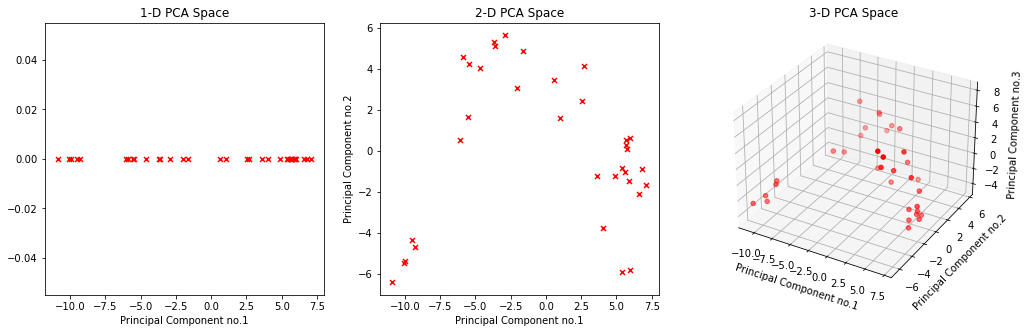

In [143]:
# Choose our number of principal components
k = 3

# Compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X,k)

# Plot 34 samples in 1D, 2D and 3D PCA spaces
fig = plt.figure(figsize=(17,17))

ax1 = fig.add_subplot(331)
ax1.scatter(X_pca[:,0],np.zeros(len(X_pca[:,0])), 25, 'r' ,'x');
ax1.set_xlabel('Principal Component no.1')
ax1.set_title('1-D PCA Space')

ax2 = fig.add_subplot(332)
ax2.scatter(X_pca[:,0],X_pca[:,1], 25, 'r' ,'x');
ax2.set_xlabel('Principal Component no.1')
ax2.set_ylabel('Principal Component no.2')
ax2.set_title('2-D PCA Space')

ax3 = fig.add_subplot(333, projection='3d')
ax3.scatter(X_pca[:,0],X_pca[:,1], X_pca[:,2], color='r')
ax3.set_xlabel('Principal Component no.1')
ax3.set_ylabel('Principal Component no.2')
ax3.set_zlabel('Principal Component no.3')
ax3.set_title('3-D PCA Space')

plt.show()

#### Analysis

Comparing these projections with the clustering results obtained in 2.1, it is apparent that visually there are no apparent or distinct clusters.

In particular, looking at the 2D projection, the data appears very spread out. Referring to robustness, it appears that any possible clustering of the dataset would result in a low density of clusters as well as low separation, hence the dataset does not appear robust. In addition, the number of clusters is highly subjective from my perspective. One could argue the dataset could be split into 2 clusters but potentially also 3 or 4 clusters. This matches with my analysis from 2.1, where despite finding an optimal number of clusters from more quantitative measures such as the within-cluster distance suggesting $k=4$ and the CH-score suggesting $k=2$, it was still clear that these optimal clusterings were not significantly better than the rest.

These observations can be explained since these PCA projections must be able to clearly capture a significant proportion of the original dataset, even just with $d=1,2,3$ dimensions and therefore we are able to identify potential clusterings which match our analysis from 2.1 from all 100 features.

#### 2.2.2 - Explained Variance

Now we can calculate the proportion of explained variance of the PCA approximations of reduced dimensionality d by taking the eigenvalue of each principal component and dividing each by the sum of all eigenvalues. We can then plot the explained variance for all values of d in the interval $[1,10]$.

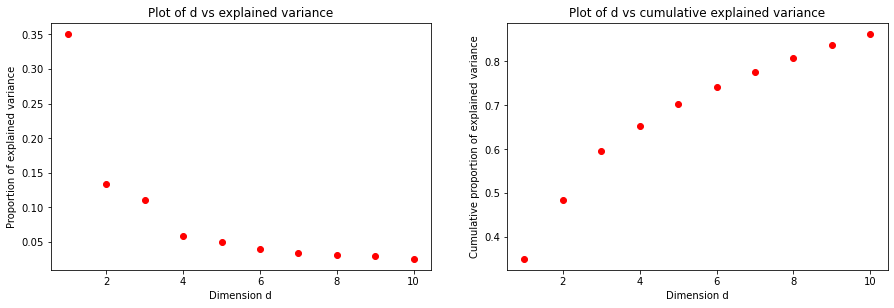

In [144]:
C = 1.0/(len(X)-1) * np.dot(X.T, X)
all_eigenvalues, _ = np.linalg.eig(C)
all_eigenvalues = np.real(all_eigenvalues)
total_variance = abs(all_eigenvalues.sum())

explained_variances = all_eigenvalues /  total_variance
cumulative_ev = np.cumsum(explained_variances)

fig = plt.figure(figsize=(15,10))
# Plot the dimensionality d against the explained variance for d from 1 to 10.
ax1 = fig.add_subplot(221)
ax1.scatter(np.arange(1,11), explained_variances[0:10], color='r');
ax1.set_xlabel('Dimension d')
ax1.set_ylabel('Proportion of explained variance')
ax1.set_title('Plot of d vs explained variance')

# Plot the dimensionality d against the cumulative explained variance for d from 1 to 10.
ax2 = fig.add_subplot(222)
ax2.scatter(np.arange(1,11),cumulative_ev[0:10], color='r');
ax2.set_xlabel('Dimension d')
ax2.set_ylabel('Cumulative proportion of explained variance')
ax2.set_title('Plot of d vs cumulative explained variance')

plt.show()

#### Analysis

Using the explained variance, we can find indicators that the dataset would be well described in a reduced dimension, lower than the original dimension of the dataset $D = 100$. This may be the case since some of the 100 features may be unnecessary or redundant, due to some features being correlated for example. We can gain a measure of this error, between the dataset of reduced dimensionality and the original dataset, by considering the spectral decomposition of $F^T F$, where $F$ is our $34 \times 100$ feature matrix. 

By plotting the eigenvalues of the matrix $F^T F$ in descending order, with the number of principal components on the x axis, we look to obtain an optimal reduced dimension of the dataset by looking to minimise the error (represented as the sum of the eigenvalues discarded) as well as keeping the actual dimension number low. This can be observed graphically if the eigenvalues appear to drop drastically at some point - the optimal dimension to reduce the dataset will be the dimension prior to the drop.

We can already identify from the first graph, that the noticeable drops in eigenvalue appear after $d=1$ and $d=3$, which could very well indicate that the data can be well described in reduced dimensionality with $d=1$ or $d=3$, since $d=1$ captures roughly 35% of the dataset's information and $d=3$ captures roughly 60% of the dataset, as seen from the cumulative explained variance graph. There is a noticeable kink in the plot at $d=3$, which indicates that past this point, the cumulative explained variance does not increase as much per increment of $d$.

However we still want to look past $d=10$ to identify other potential dimensions to reduce our dataset to. Below are the plots of dimension against the corresponding eigenvalue, but also dimension against the log of the eigenvalue, for $d$ up to 100.

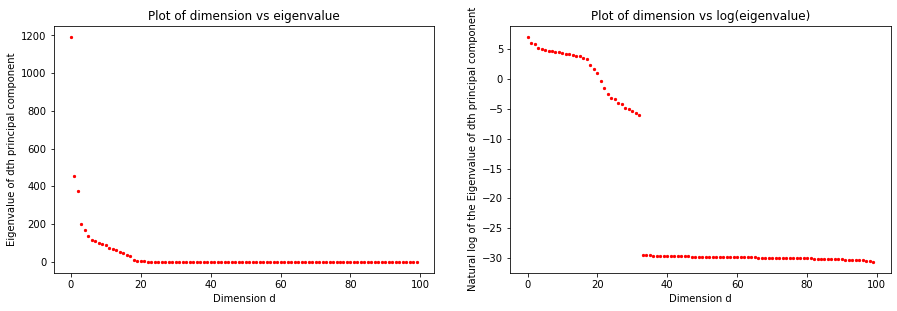

In [145]:
SD = X.T @ X
eigenvalues, _ = np.linalg.eig(SD)
eigenvalues = np.sort(np.real(eigenvalues))[::-1]

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
ax1.scatter(np.arange(100), eigenvalues, 5, 'r' ,'o');
ax1.set_xlabel('Dimension d')
ax1.set_ylabel('Eigenvalue of dth principal component')
ax1.set_title('Plot of dimension vs eigenvalue')

ax2 = fig.add_subplot(222)
# Small term added to ensure log(0) is not computed
ax2.scatter(np.arange(100), np.log(eigenvalues + 1e-13), 5, 'r' ,'o');
ax2.set_xlabel('Dimension d')
ax2.set_ylabel('Natural log of the Eigenvalue of dth principal component')
ax2.set_title('Plot of dimension vs log(eigenvalue)')

plt.show()

#### Analysis

Another case could be made for $d=18$, where the graph also does decrease by a significantly larger amount than neighbouring eigenvalues, and captures 99.4% of the explained variance.

Past this point however, it is difficult to distinguish eigenvalues and thus any drastic drops, since they are all so close to zero. Because of this, I have plotted a logarithmic graph of the eigenvalues, to better describe the drops for such small eigenvalues. From this second graph however, it is obvious that $d = 33$ is the optimal reduced dimension of the dataset due to the incredibly large drop in eigenvalue from $d = 33$ to $d = 34$, of a order of magnitude of $10^{10}$. From a linear algebra perspective, this seems to make intuitive sense. Since our original feature matrix $F$ is a 34 $\times$ 100 array, we already know that we can reduce the number of columns to be at most 34 since at least 66 columns will be linear combinations of the others. Since we find $d=33$ and hence the number of columns can be reduced to 33 in fact, we can deduce that there was one more column which was a linear combination of the others columns and so we end with 33 principal components which still capture almost the entirety of the original dataset.

Overall, there are certainly indications that the dataset is well described in a reduced dimension, whether it is $d=1, 3, 18$ or $33$, by looking at the spectral decomposition of $F^T F$.

### 2.3 - Graph-based Analysis

#### 2.3.1 - Centralities

In this section, we aim to analyse the friendship graph encoded by the adjacency matrix $A$. We can obtain three measures of centrality, namely:
* Degree Centrality
* Eigenvector Centrality
* PageRank Centrality

We can produce code which returns each measure of centrality and apply them to the karate club graph as follows:

In [146]:
# Import adjacency matrix
K = pd.read_csv('karate_club_graph.csv', header= None)
A = K.values[1:,1:]

#### Degree Centrality

Degree centrality can be calculated using the following formula:
$$
\boldsymbol{c}_d = \frac{A \mathbb 1}{2E}
$$
where $A$ is the adjacency matrix and $E = 78$ is the number of edges.

In [147]:
def degree_centrality(A):
    # Compute the degree of the adjacency matrix
    degree = A.sum(axis=1)
    # Compute degree centrality using the above formula
    cD = degree/(2*78)
    return cD

cD = degree_centrality(A)
print('Degree centrality = ', cD)

Degree centrality =  [0.1025641  0.05769231 0.06410256 0.03846154 0.01923077 0.02564103
 0.02564103 0.02564103 0.03205128 0.01282051 0.01923077 0.00641026
 0.01282051 0.03205128 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01923077 0.01282051 0.01282051 0.01282051 0.03205128
 0.01923077 0.01923077 0.01282051 0.02564103 0.01923077 0.02564103
 0.02564103 0.03846154 0.07692308 0.10897436]


#### Eigenvector Centrality
Eigenvector centrality can be calculated using the following formula:
$$
\boldsymbol{c}_e(i) = \alpha \sum_j A_{ij}\boldsymbol{c}_e(j)
$$
which can be understood as an eigenvector solution:
$$
A \boldsymbol{c}_e = \lambda \boldsymbol{c}_e
$$

Hence the eigenvector centrality is the leading eigenvector of the matrix $A$ i.e. the eigenvector with the largest eigenvalue.

In [148]:
def eigenvector_centrality(A):
    # Compute the eigenvector associated with the largest eigenvalue
    eigenvalue, eigenvector = linalg.eigsh(A, 1, which="LM", return_eigenvectors=True)
    # Compute eigenvector centrality using the eigenvector, ensuring it the positive variant and normalised
    cE = np.abs(eigenvector)/np.sum(eigenvector)
    cE = cE.reshape(34,)
    return cE

cE = eigenvector_centrality(A)
print('(Normalised) Eigenvector centrality = ',cE)

(Normalised) Eigenvector centrality =  [0.07141273 0.05342723 0.06371906 0.04242274 0.01526096 0.01596691
 0.01596691 0.03434317 0.04568193 0.02062567 0.01526096 0.01061789
 0.01692545 0.04549486 0.02037035 0.02037035 0.00474803 0.01856164
 0.02037035 0.02971333 0.02037035 0.01856164 0.02037035 0.0301565
 0.01146095 0.01189366 0.01518273 0.02681349 0.02633151 0.02711154
 0.03510624 0.03837574 0.06200185 0.07500294]


#### PageRank Centrality

PageRank centrality can be calculated using the following formula, with $\alpha = 0.85$, $N = 34$, $D = diag(A \mathbb{1})$:
$$
\boldsymbol{c}_{PR} = \alpha(AD^{-1})\boldsymbol{c}_{PR} + (1-\alpha)\frac{\mathbb{1}}{N}
$$
This can be reduced to a linear equation:
$$
[ \alpha(AD^{-1})-{Id}_N ] \boldsymbol{c}_{PR} = (1-\alpha)\frac{\mathbb{1}}{N}
$$
And hence we can solve for the pagerank centrality:
$$
\boldsymbol{c}_{PR} = [ \alpha(AD^{-1})-{I}_N ]^{-1}(1-\alpha)\frac{\mathbb{1}}{N}
$$

In [149]:
from scipy.stats import rankdata

def pagerank_centrality(A, alpha):
    # define diagonal matrix of node degrees
    weighted_degree = A.sum(axis=1) 

    # create diagonal matrix of degree
    D = np.diag(weighted_degree)
    invD = np.linalg.inv(D)

    # Initialise value for N
    N = len(A)

    # Compute pagerank centrality using formula for page rank centrality
    cPR = np.linalg.solve((np.identity(N)-(alpha*A @ invD)), np.ones(N)*(1-alpha)*(1/N))
    return cPR

cPR = pagerank_centrality(A, 0.85)
print('PageRank centrality = ', cPR)

PageRank centrality =  [0.09699729 0.05287692 0.05707851 0.03585986 0.02197795 0.02911115
 0.02911115 0.0244905  0.02976606 0.0143094  0.02197795 0.00956475
 0.01464489 0.02953646 0.01453599 0.01453599 0.01678401 0.01455868
 0.01453599 0.01960464 0.01453599 0.01455868 0.01453599 0.03152251
 0.02107603 0.0210062  0.01504404 0.02563977 0.01957346 0.02628854
 0.02459016 0.03715809 0.07169323 0.10091918]


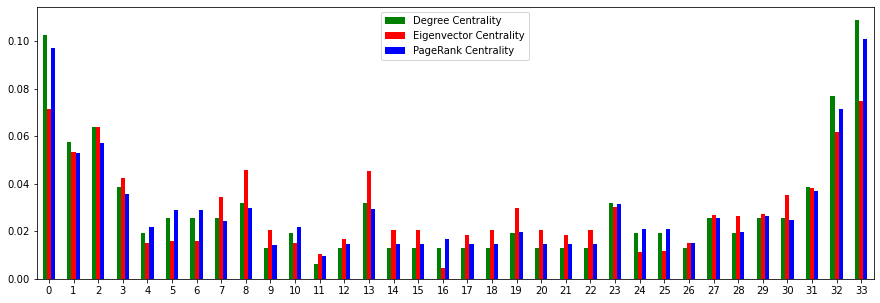

In [150]:
# Concatenating normalised vectors of centralities into one array
c = pd.DataFrame(np.vstack((cD, cE, cPR)).T)
# Relabelling columns according to centrality type
c.columns = ['Degree Centrality', 'Eigenvector Centrality', 'PageRank Centrality']
# Plotting centralities on grouped bar chart
ax = c.plot.bar(rot=0, figsize=(15,5),color={"Degree Centrality": "green", "Eigenvector Centrality": "red", "PageRank Centrality": "blue"})

By plotting the grouped bar chart of all centralities above, it is evident that the nodes which are highly central according to all 3 centralities are nodes 0, 1, 2, 32 and 33.

#### Spearman's Rank Correlation Coefficient

We can now observe the correlation between the node rankings of the different centrality measures. We can use seaborn to visualise the similarities between the rankings, as well as calculate the Spearman's Rank Correlation Coefficient between pairs of centralities to quantitatively gauge the similarity.

We can plot 3 scatter graphs of pairs of centrality values, alongside calculating the Spearman's rank correlation coefficient. This is because we are interested in the node ranking correlations specifically, not the actual values of the centralities like the Pearson correlation coefficient would calculate.

Degree vs Eigenvector : Spearmans Rank Correlation Coefficient =    0.7752555221953447
Degree vs PageRank : Spearmans Rank Correlation Coefficient =       0.978925432059701
Eigenvector vs PageRank : Spearmans Rank Correlation Coefficient =  0.6750353974114367


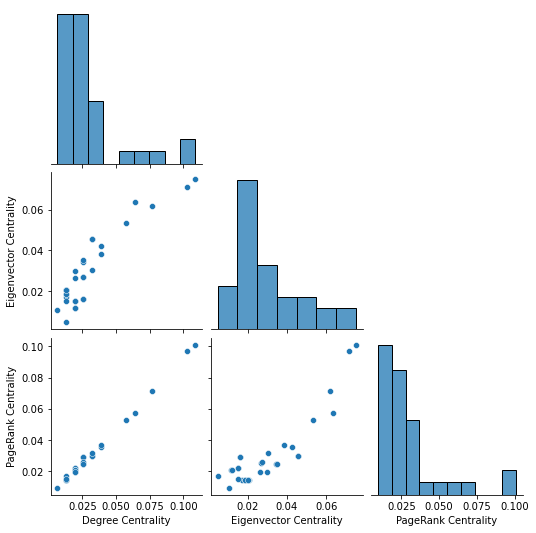

In [151]:
from scipy.stats import spearmanr
import seaborn as sns

# Use seaborn to as visualisation for the scatter plots of each centrality measure against another
sns.pairplot(c, corner=True);

# Calculating Spearman's Rank Correlation Coefficient between pairs of centralities
cD_cE = spearmanr(c.iloc[:,0], c.iloc[:,1])[0]
cD_cPR = spearmanr(c.iloc[:,0], c.iloc[:,2])[0]
cE_cPR = spearmanr(c.iloc[:,1], c.iloc[:,2])[0]

print('Degree vs Eigenvector : Spearmans Rank Correlation Coefficient =   ', cD_cE)
print('Degree vs PageRank : Spearmans Rank Correlation Coefficient =      ', cD_cPR)
print('Eigenvector vs PageRank : Spearmans Rank Correlation Coefficient = ', cE_cPR)

#### Analysis

Evidently, there is a high rank correlation between the degree centrality and the pagerank centrality, whereas the correlations involving eigenvector centrality are substantially lower.

The reasons for the differences in the centrality rankings is because they all measure slightly different things. Degree centrality is a simple measure of the number of connections each node has, whereas eigenvector centrality also takes into account how popular their connections are, and how popular the connections of their connections are, throughout the entire network. PageRank is also different, since it models a probability distribution to represent the likelihood that a web surfer randomly clicking links will arrive at that particular website, incorporating a damping factor $\alpha$ which represents the probability a person will continue clicking.

The reason for eigenvector centrality being different from degree and pagerank centrality is perhaps because if we have a network where there are many instances of highly central people with many connections, but those connections themselves do not have many connections, then this creates a large difference between the degree and the eigenvector centralities, for example. This is because those highly central people will have a lower eigenvector centrality, since this is also a measure of how popular their connections are. Essentially, popular people have unpopular connections, whereas unpopular people have popular connections, which leads to a disparity between rankings of degree centrality and eigenvector centrality. Perhaps this is the scenario within the karate club, where there are few popular people with many unpopular connections, leading to a divergence in centralities.

We do observe however a high rank correlation between degree and pagerank centrality, which arises since the pagerank of an undirected graph is similar to the degree centrality. This is further explored and explained in 2.3.2.

#### 2.3.2 - Community Detection

Now we aim to use NetworkX to compute the optimal number of communities $k^*$ and the corresponding partition of the karate club graph by using the Clauset-Newman-Moore greedy modularity maximisation algorithm.

In [152]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

In [153]:
# Create NetworkX graph from adjacency matrix
G = nx.Graph(A)
# Call the greedy modularity maximisation algorithm in NetworkX
C = greedy_modularity_communities(G)
print('Optimal partition of karate club:', C)

Optimal partition of karate club: [frozenset({32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}), frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21}), frozenset({0, 4, 5, 6, 10, 11, 16, 19})]


Hence we observe the the optimal number of communities is $k^* = 3$ and its corresponding partition of nodes from 0 to 33, with communities of size 17, 9 and 8.

We can now use NetworkX to plot the obtained clusters on the graph, with nodes belonging to the same community assigned to the same colour:

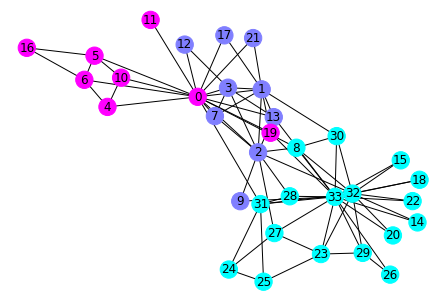

In [154]:
# Initialise labels for community classes for each node
C_label = np.zeros(34).astype(int)

# Algorithm to assign a community label for each node based on greedy modularity communities
for i in range(34):
    for j in range(3):
        if i in C[j]:
            C_label[i] = j

# Draw graph to highlight which community each node belongs in 
nx.draw(G, node_color=C_label, with_labels=True, cmap=plt.cm.cool)

Now we aim to obtain the global top 8 most central nodes according to degree and pagerank centrality across the $k^*$ communities.

First we create a function which outputs the top 8 nodes given a centrality measure. We aim to use this function on the degree and pagerank centrality measures.

In [155]:
from operator import itemgetter

# Define function to identify top 8 nodes by value
def top_8_nodes(centrality):
    # Enumerate data
    arguments = enumerate(centrality)
    # Sort nodes by centrality value in reverse order
    sorted_arguments = sorted(arguments, key=itemgetter(1))[::-1]
    return [d[0] for d in sorted_arguments[:8]]

In [156]:
# Print top 8 nodes for degree centrality and pagerank centrality
top_8_cD = top_8_nodes(cD)
top_8_cPR = top_8_nodes(cPR)
print('Degree centrality - top 8 nodes:', top_8_cD)
print('PageRank centrality - top 8 nodes:', top_8_cPR)

Degree centrality - top 8 nodes: [33, 0, 32, 2, 1, 31, 3, 23]
PageRank centrality - top 8 nodes: [33, 0, 32, 2, 1, 31, 3, 23]


Evidently, we appear to gain the exact same distribution of top 8 nodes for degree and pagerank centralities. The reason for the high correlation between the rankings of degree centrality and pagerank is because for an undirected graph e.g. the karate club graph, the pagerank centrality is very similar to the degree centrality. The difference is due to the damping factor $\alpha = 0.85$; if $\alpha \to 1$ i.e. the 'web surfer' never stops clicking, then the pagerank centrality approaches the degree centrality (assuming the degree centrality is normalised by $2E$ and not $N-1$). The effect of the damping factor lessens the pagerank of the more central nodes, and increases the pagerank of the less central nodes - however since $\alpha = 0.85$ is still quite high, these differences are not too large, hence the rankings are near identical since this scaling mostly preserves the node rankings. Any disparity is simply because the degree centrality is a more discrete measure, and so many ranks are tied and hence averaged.

It is however important to note that for degree centrality, nodes 31 and 3 are tied for value and node 23 is tied with two other nodes which are not listed in the top 8. This is due to the nature of degree centrality taking discrete values and therefore distinct rankings are more difficult to obtain, however this still gives us a strong indication of the top 8 most central nodes of the karate club.

Now we aim to plot the top 8 most central nodes (from either degree or pagerank centrality, since they are equivalent) and observe its distribution across the 3 communities.

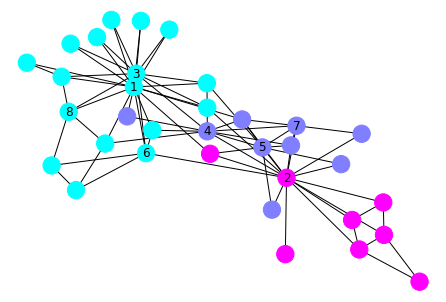

In [157]:
# Algorithm to plot graph with top 8 nodes indicated by their ranking
# Initialise top 8 labels as a dictionary
top_8_labels = {}

# Check if node is in the top 8
for i in range(34):
    if i in top_8_cD:
        top_8_labels[i] = top_8_cD.index(i)+1
    else:
        top_8_labels[i] = ''

# Draw graph with communities and top 8 nodes labelled
nx.draw(G, node_color=C_label, labels=top_8_labels, with_labels=True, cmap=plt.cm.cool)

Here we see the top 8 nodes are somewhat spread over the 3 communities, loosely according to the size of each community. We have 4 top nodes in the largest community of size 17, 3 top nodes in the community of size 9 and 1 in the smallest of size 8. Of course once again, these numbers are not exact since the 8th most central node for degree centrality is node 23, which was also tied with node 8 and node 13 - node 13 belongs to a different community for example.

This distribution can be explained from the nature of the greedy modularity maximisation algorithm, the aim is to maximise the 'modularity' of the partition which involves ensuring that edges within communities are more common than edges between communities. This implies that typically highly central nodes that do not share an edge, will also not be in the same community - if they were, then it is very unlikely they will not share an edge or the modularity measure would decrease as connections to both central nodes. Highly central nodes almost define their own communities if they arent connected to each other, especially with a relatively low number of nodes to begin with. 

Applying this theory to the above graph, we observe that the 1st and 2nd most central nodes are not connected to each other, and are in their own community. The 3rd node is connected to the 1st node, hence they are in the same community too because they will have many common connections between them. It is important to note this rule does not always apply, and the greedy modularity max function is just an approximation to finding the maximum modularity partition, however this does help somewhat explain the distribution of the top 8 nodes across the 3 communities.

#### 2.3.3 - Adjusted Rand Index for comparing clusterings

We can now proceed to code the Adjusted Rand Index (ARI) to quantify how similar the optimal clusterings in 2.1.2 and 2.3.2 are to each other. In 2.1.2, we observed from the CH-score that $k=2$ clusters was optimal, however in 2.3.2 we have obtained $k^* = 3$ as the optimal clustering. 

We can compute the ARI by considering the contingency table between both clusterings. We can apply a formula using the values from the contingency matrix, alongside creating a function for n choose 2 to ease the computation.

$$
ARI = \frac{\sum_{ij} {n_{ij} \choose 2} -  [\sum_i {a_i \choose 2} \sum_j {b_j \choose 2}] / {n\choose 2}}{\frac{1}{2}  [\sum_i {a_i \choose 2} \sum_j {b_j \choose 2}] -  [\sum_i {a_i \choose 2} \sum_j {b_j \choose 2}] / {n\choose 2}}
$$

where $a_i$ is the sum of the ith row, $b_j$ is the sum of the jth column and $n_{ij}$ is the value in the ith row, jth column.

In [158]:
# Define n choose 2 function to use in ARI formula
def nC2(n):
    return (n)*(n-1)/2

def ARI(clustering1, clustering2):
    
    # Find optimal k for both clusterings
    k1 = max(clustering1)+1
    k2 = max(clustering2)+1
    
    # Create contingency matrix
    contingency = np.zeros((k1,k2))
    for k in range(34):
        for i in range(k1):
            for j in range(k2):
                if clustering1[k] == i and clustering2[k] == j:
                    contingency[i, j] += 1
    
    # Calculate values to input into ARI formula
    sum_cntgncy_c2 = np.sum(nC2(contingency))
    sum_a_c2 = sum(nC2(sum(contingency[i])) for i in range(k1))
    sum_b_c2 = sum(nC2(sum(contingency[:,i])) for i in range(k2))
    
    # Compute ARI from previous values of both sets of labels
    ARI = (sum_cntgncy_c2 - (sum_a_c2 * sum_b_c2)/nC2(34)) / ( 0.5*(sum_a_c2 + sum_b_c2) - (sum_a_c2 * sum_b_c2)/nC2(34))
    return ARI

k_means_label = k_means(2)[1]
C_label = C_label.astype(int)

print('Adjusted Rand Index between k-means and greedy modularity communities clusterings = ', ARI(k_means_label, C_label))

Adjusted Rand Index between k-means and greedy modularity communities clusterings =  -0.031487014479429976


We now have a value for the ARI between the optimal clusterings of 2.1.2 and 2.3.2 of -0.03. Since this value is very close to zero, it suggests there is a near-random correlation between both clusterings and hence are not similar at all.

We can also calculate the ARI between both these clusterings and the ground truth split, as observed below. First by importing the data, and converting the labels of 'Mr. Hi' and 'Officer' to 0 and 1 respectively.

In [159]:
# Import ground truth matrix
gt = pd.read_csv('ground_truth_karate_club.csv', header= None)
GT = gt.values[1:,1:]
GT_labels = np.empty(34)
for i in range(34):
    if (GT[i] == 'Mr. Hi'):
        GT_labels[i] = 0
    else:
        GT_labels[i] = 1
GT_labels = GT_labels.astype(int)

print('Adjusted Rand Index between k-means and ground truth clusterings = ', ARI(k_means_label, GT_labels))
print('Adjusted Rand Index between ground truth and greedy modularity communities clusterings = ', ARI(GT_labels, C_label))

Adjusted Rand Index between k-means and ground truth clusterings =  0.0012970168612192327
Adjusted Rand Index between ground truth and greedy modularity communities clusterings =  0.5684394071490846


#### Analysis

Here we observe once again a substantial dissimilarity between the optimal k-means clustering and the ground truth clustering with an ARI of 0.00129 i.e. very close to 0. However the ARI between greedy modularity communities and ground truth is at a significant 0.568 (3.d.p) which suggests a more significant similarity between both these clusterings.

This perhaps suggests that the optimal clustering of the data with Zachary's Karate Club is best attained through viewing social friendships and connections between members, rather than attempting to draw a correlation between the features of individual members. The PCA dimension reductionality of the feature matrix already indicated that at least 67 of the features were redundant, but still the remaining features still were not able to obtain a clustering which matched the real-life partition of the karate club.

However, an ARI of 0.568 is still not suggestive of a very high similarity between the greedy modularity communities and the ground truth. This may be due to the different number of clusters of both sets of labels. We may have obtained $k^* = 3$ from the greedy modularity algorithm but this is perhaps since it is only an approximation of maximising the modularity, hence some accuracy was lost. Nevertheless, upon closer inspection of both labels, it appears that merging communities 1 and 2 into one (leaving 0) may yet improve the ARI obtained.

Below I have created a new vector of labels, derived from the greedy modularity maximisation algorithm, which combines both of the smaller communities. We can see if this partition obtains a higher ARI when compared with the ground truth labels.

In [160]:
# Initialise labels for community classes for each node
C_label_2 = np.zeros(34).astype(int)

# Algorithm to assign a community label for each node based on greedy modularity communities, combining community 1 and 2
for i in range(34):
    if i in C[0]:
        C_label_2[i] = 0
    else:
        C_label_2[i] = 1

print('Adjusted Rand Index between ground truth and updated greedy modularity communities = ', ARI(C_label_2, GT_labels))
        

Adjusted Rand Index between ground truth and updated greedy modularity communities =  0.7716262975778547


Interestingly enough, we obtain a significantly higher ARI with our adjusted modularity community partition. 

Overall, it is evident that the modularity maximisation algorithm on connections between members is a much more effective method of creating a partition than applying a k-means algorithm to cluster the feature matrix associated with each member.